# GetPeople - Find Your Lost People
Find your lost people with us!

# Import Libraries and Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import cv2  # Ini kayaknya ga kepake
import tensorflow as tf
import collections

from IPython.display import clear_output # Ini aku yg tambahin buat hapus output yang ga perlu

# Tensorflow
from tensorflow.keras import applications # Ini kayaknya ga kepake
from tensorflow.keras import layers
from tensorflow.keras import losses       # ini juga
from tensorflow.keras import optimizers   # ini juga
from tensorflow.keras import metrics      # ini juga
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet  # ini juga

# ScikitLearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split  # ini juga

clear_output()

# Dataset

## Utility Functions

In [2]:
## This function for making pairs  
## (both positive and negative pairs)
def generate_pairs(images, labels):
  # Generate label and index
  label_unique = np.unique(labels)                  # make a dictionary like this :
  label_indices = collections.defaultdict(list)     # label_indices = {
  i = 0                                             # 0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
  for idx, label in enumerate(labels):              # 1: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
    if label == i:                                  # ...
      label_indices[label].append(idx)              # }
    else:
      i += 1

  # Generate image and labels pairs
  pair_images = []
  pair_labels = []
  for idx, image in enumerate(images):
    # positive pairs
    indices = label_indices.get(labels[idx])     # indices = [11, 12, 13, 14, 15, 16, 17, 18, 19]
    positive = images[np.random.choice(indices)] # image = take random image from index above
    pair_images.append((image, positive))        # make a positive pairs
    pair_labels.append(1)                        # (+) pairs labeled with 1

    # negative pairs
    indices = np.where(labels != labels[idx])         # neg_indices = other indices from indices above 
    negative = images[np.random.choice(indices[0])]   # neg_indices[0] -> take array from list
    pair_images.append((image, negative))             # make a negative pairs
    pair_labels.append(0)                             # (-) pairs labeled with 0
      
  return np.array(pair_images), np.array(pair_labels)

## Prepare Data

In [3]:
# Get the GDrive paths
# https://drive.google.com/file/d/1RWfKbQB-OMD8bIeyM0GnqovCA3VOWZgw/view?usp=sharing

# Download file from gdrive and use only the ID from GDrive paths
!gdown 'https://drive.google.com/uc?id=1RWfKbQB-OMD8bIeyM0GnqovCA3VOWZgw'

# Unzip the file
!unzip /content/olivetti.zip
clear_output()

In [4]:
# Get the data directory paths
images_path = '/content/olivetti_faces.npy'
labels_path = '/content/olivetti_faces_target.npy'

# Load the images and labels
face_images = np.load(images_path)
face_labels = np.load(labels_path)

# Define the target shape
target_shape = face_images[0].shape

# Make a pairs of image, set label, and shuffle the dataset
images_dataset, labels_dataset = generate_pairs(face_images, face_labels)
images_dataset, labels_dataset = shuffle(images_dataset, labels_dataset)

## Visualize

In [15]:
def show_images(images, labels, cmap = 'gray', nrows = 10, pair = False):
  """
  images = ("face_images", "images_dataset")
  images must be an three dimensional array (n, x, y) or 
  four dimensional array (n, x, y, c) if there's 3 channel

  labels = ("face_labels", "labels_dataset")
  """
  # Count nrows
  ncols = nrows if pair else 10
  nrows = 2 if pair else nrows

  # Set the fig size
  x = ncols * 1.6
  y = nrows * 1.6
  figsize = (x, y)

  if pair:
    n = images.shape[0]
    p = images.shape[1]
    x, y = images.shape[2], images.shape[3]
    images = images.reshape(n*p, x, y)

  # Image
  fig,ax = plt.subplots(nrows, ncols,
                        figsize = figsize,
                        subplot_kw = dict(xticks=[], yticks=[]))  # remove x and y axis
  if pair:
    fig.suptitle('This is sample of {} pair faces.'.format(ncols), fontsize = 16)
    for col in range(ncols):
      for row in range(nrows):
        ax[row, col].imshow(images[col*nrows + row], cmap = cmap)   # print the images
        ax[1, col].set_xlabel(labels[col])                          # print the labels
  else:
    fig.suptitle('This is sample of {} faces of {} person.'.format(nrows*ncols, nrows),
                 fontsize = 16)
    for row in range(nrows):
      for col in range(ncols):
        ax[row, col].imshow(images[row*ncols + col], cmap = cmap)   # print the images
        ax[row, col].set_xlabel(labels[row*ncols + col])            # print the labels
  plt.show()

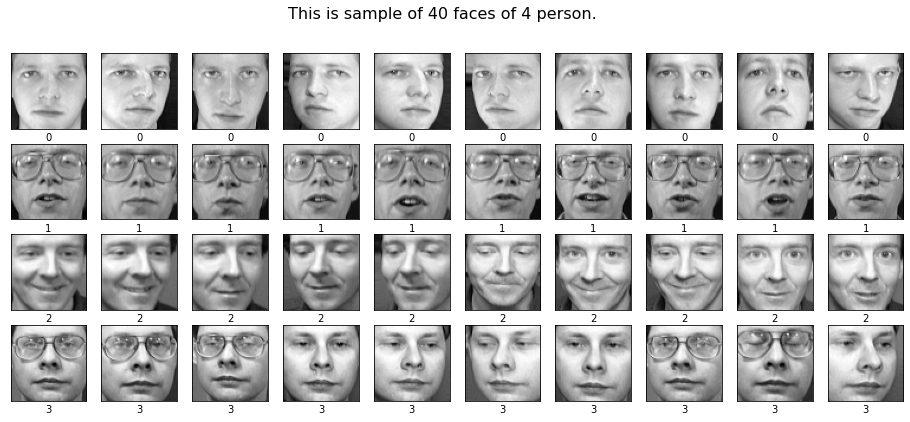

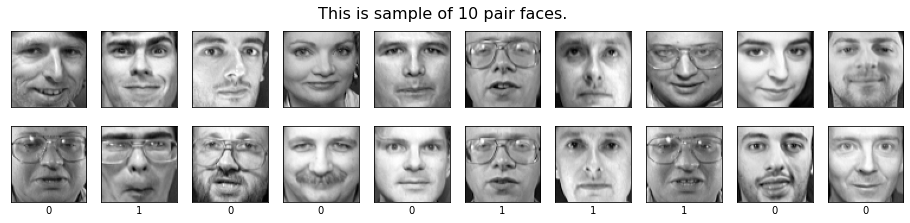

In [17]:
show_images(images = face_images, labels = face_labels, nrows = 4, pair = False)
show_images(images = images_dataset, labels = labels_dataset, nrows = 10, pair = True)

# Network Architecture

## Embedding Layer

In [ ]:
layers.Conv2D()

In [12]:
inputs = layers.Input((64, 64, 1))

x = layers.Conv2D(64, (10, 10), padding="same", activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128, (7, 7), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128, (4, 4), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(256, (4, 4), padding="same", activation="relu")(x)
fcOutput = layers.Flatten()(x)
fcOutput = layers.Dense(4096, activation = "relu")(fcOutput)
outputs = layers.Dense(1024, activation = "sigmoid")(fcOutput)

embedding = Model(inputs, outputs, name = "Embedding")

## Siamese Network

In [13]:
import tensorflow.keras.backend as K

In [14]:
# Define the Contrastive Loss
def contrastive_loss(y, preds, margin=1):
    y = tf.cast(y, preds.dtype)
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)

    return loss

In [15]:
# Distance Layer
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance
    between the embeddings
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, compare):
        sum_squared = K.sum(K.square(anchor - compare), axis=1, keepdims=True)
        return K.sqrt(K.maximum(sum_squared, K.epsilon()))

In [16]:
anchor_input = layers.Input(name="anchor", shape=target_shape + (1,))
compare_input = layers.Input(name="compare", shape=target_shape + (1,))

distances = DistanceLayer()(
    embedding(anchor_input),
    embedding(compare_input),
)

outputs = layers.Dense(1, activation = "sigmoid") (distances)

siamese_model = Model(
    inputs=[anchor_input, compare_input], outputs=outputs
)

# Training

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
checkpoints = ModelCheckpoint('Model' + '{accuracy:.2f}acc.h5', verbose=1) # Create Keras SavedModel as checkpoints

In [18]:
siamese_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = siamese_model.fit([images_dataset[:, 0, :], images_dataset[:, 1, :]], labels_dataset,
                            epochs=150, validation_split = 0.2, batch_size = 64)

Epoch 1/150
10/10 [==============================] - 19s 285ms/step - loss: 0.6757 - accuracy: 0.5078 - val_loss: 0.6211 - val_accuracy: 0.5188
Epoch 2/150
10/10 [==============================] - 1s 136ms/step - loss: 0.6415 - accuracy: 0.5078 - val_loss: 0.6359 - val_accuracy: 0.5188
Epoch 3/150
10/10 [==============================] - 1s 133ms/step - loss: 0.6524 - accuracy: 0.5078 - val_loss: 0.6288 - val_accuracy: 0.5312
Epoch 4/150
10/10 [==============================] - 1s 120ms/step - loss: 0.6312 - accuracy: 0.5078 - val_loss: 0.6098 - val_accuracy: 0.5375
Epoch 5/150
10/10 [==============================] - 1s 128ms/step - loss: 0.6151 - accuracy: 0.5094 - val_loss: 0.6241 - val_accuracy: 0.5437
Epoch 6/150
10/10 [==============================] - 1s 130ms/step - loss: 0.6075 - accuracy: 0.5141 - val_loss: 0.6203 - val_accuracy: 0.5562
Epoch 7/150
10/10 [==============================] - 1s 124ms/step - loss: 0.5928 - accuracy: 0.5203 - val_loss: 0.5983 - val_accuracy: 0.537

In [19]:
siamese_model.save('/content/')

INFO:tensorflow:Assets written to: /content/assets


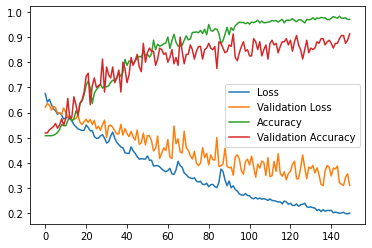

In [20]:
# Training Plot
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["Loss", "Validation Loss", "Accuracy", "Validation Accuracy"])

# Testing

In [21]:
def test_visualize(images, n = 5):
    """ Visualize a few images """

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9)) 
    axs = fig.subplots(1, n)
    for i in range(n):
        show(axs[i], images[i])

## Test 1

In [22]:
test_indices = [0, 1, 2, 3, 4]
test_index = random.sample(range(10), 1)[0]
test_image = face_images[test_index]

compare_images = []
for i in range(5):
    index = random.sample(range(i * 10, (i + 1) * 10), 1)[0]
    image = face_images[index]
    compare_images.append(image)

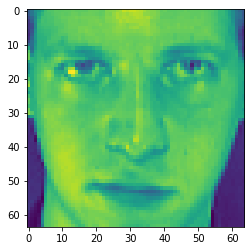

In [23]:
plt.imshow(test_image)

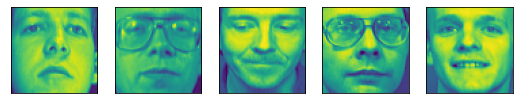

In [24]:
test_visualize(compare_images)

In [25]:
image_pairs = []

for image in compare_images:
    image_pairs.append((test_image, image))
    
image_pairs = np.array(image_pairs)

In [26]:
image_pairs.shape

(5, 2, 64, 64)

In [27]:
image_pairs[:,0,:]

array([[[0.3181818 , 0.40082645, 0.49173555, ..., 0.40082645,
         0.3553719 , 0.30991736],
        [0.30991736, 0.3966942 , 0.47933885, ..., 0.40495867,
         0.37603307, 0.30165288],
        [0.26859504, 0.34710744, 0.45454547, ..., 0.3966942 ,
         0.37190083, 0.30991736],
        ...,
        [0.1322314 , 0.09917355, 0.08264463, ..., 0.13636364,
         0.14876033, 0.15289256],
        [0.11570248, 0.09504132, 0.0785124 , ..., 0.1446281 ,
         0.1446281 , 0.1570248 ],
        [0.11157025, 0.09090909, 0.0785124 , ..., 0.14049587,
         0.14876033, 0.15289256]],

       [[0.3181818 , 0.40082645, 0.49173555, ..., 0.40082645,
         0.3553719 , 0.30991736],
        [0.30991736, 0.3966942 , 0.47933885, ..., 0.40495867,
         0.37603307, 0.30165288],
        [0.26859504, 0.34710744, 0.45454547, ..., 0.3966942 ,
         0.37190083, 0.30991736],
        ...,
        [0.1322314 , 0.09917355, 0.08264463, ..., 0.13636364,
         0.14876033, 0.15289256],
        [0.1

In [28]:
score = siamese_model.predict([image_pairs[:, 0, :], image_pairs[:, 1, :]])

In [29]:
print(score)

[[5.0429541e-01]
 [7.8516728e-01]
 [2.5910891e-03]
 [1.3701336e-03]
 [5.5889715e-04]]


## Test 2

In [30]:
test_indices = [0, 1, 2, 3, 4]
test_index = random.sample(range(20, 30), 1)[0]
test_image = face_images[test_index]

compare_images = []
for i in range(5):
    index = random.sample(range(i * 10, (i + 1) * 10), 1)[0]
    image = face_images[index]
    compare_images.append(image)

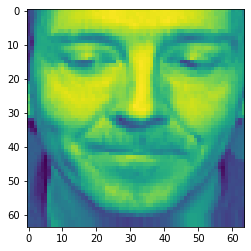

In [31]:
plt.imshow(test_image)

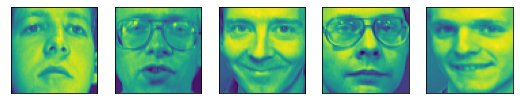

In [32]:
test_visualize(compare_images)

In [33]:
image_pairs = []

for image in compare_images:
    image_pairs.append((test_image, image))
    
image_pairs = np.array(image_pairs)

In [34]:
score = siamese_model.predict([image_pairs[:, 0, :], image_pairs[:, 1, :]])

In [35]:
print(score)

[[0.00230389]
 [0.00259374]
 [0.26610148]
 [0.13219476]
 [0.11063699]]
